# LangGraph Chatbots with Persistent SQLite Memory

This notebook demonstrates how to build conversational chatbots with persistent memory using SQLite:

- **SqliteSaver**: Persistent conversation storage
- **Database Persistence**: Conversations survive application restarts
- **Production Ready**: Suitable for real-world applications
- **Thread Management**: Separate conversation contexts with persistence
- **Interactive Chat**: Continuous conversation loop

## Use Case: Production Conversational AI

We'll build a chatbot that:
1. **Persists Conversations**: Survives application restarts
2. **Handles Multiple Users**: Thread-based isolation with database storage
3. **Interactive Interface**: Continuous chat experience
4. **Production Ready**: Suitable for deployment

This pattern is essential for:
- **Production Chatbots**: Need persistent conversation history
- **Customer Support Systems**: Long-term conversation tracking
- **Multi-session Applications**: Users return to previous conversations
- **Analytics and Monitoring**: Historical conversation data analysis

## 1. Essential Imports and Dependencies

First, let's install the required SQLite checkpoint package and import necessary components:

In [1]:
# Install the SQLite checkpoint package
!pip install langgraph-checkpoint-sqlite


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
from langgraph.checkpoint.sqlite import SqliteSaver
from IPython.display import display, Image
import sqlite3
import os

## 2. State Definition

We use the same state definition as the previous notebook, but now it will be persisted to SQLite.

### Persistence Benefits:
- **Durability**: Conversations survive application crashes
- **Scalability**: Can handle large conversation histories
- **Analytics**: Query conversation data for insights
- **Backup**: Database can be backed up and restored

In [3]:
class MyState(TypedDict):
    """State definition for our persistent conversational chatbot.
    
    This state will be automatically serialized and stored in SQLite,
    allowing conversations to persist across application restarts.
    """
    messages: Annotated[list, add_messages]

## 3. SQLite Database Setup

**SqliteSaver** provides persistent storage using SQLite database.

### Database Configuration:
- **File Location**: `checkpointer.sqlite` in the notebooks directory
- **Thread Safety**: `check_same_thread=False` for multi-threading
- **Automatic Schema**: SqliteSaver creates necessary tables

### Production Considerations:
- **Database Path**: Use absolute paths in production
- **Backup Strategy**: Regular database backups
- **Connection Pooling**: For high-concurrency applications
- **Migration Strategy**: Handle schema changes over time

### Alternative Storage Options:
- **PostgreSQL**: For larger scale applications
- **Redis**: For distributed systems
- **MongoDB**: For document-based storage
- **Cloud Databases**: AWS RDS, Google Cloud SQL, etc.

In [4]:
# Create SQLite connection for persistent storage
conn = sqlite3.connect("checkpointer.sqlite", check_same_thread=False)

print("✅ SQLite database connection established")
print(f"Database file: checkpointer.sqlite")
print(f"Connection: {conn}")

✅ SQLite database connection established
Database file: checkpointer.sqlite
Connection: <sqlite3.Connection object at 0x000002C16C8C2C50>


## 4. LLM Setup

Same LLM configuration as previous notebooks, using AWS Bedrock with Claude.

In [5]:
from dotenv import load_dotenv
from langchain_aws import ChatBedrock

load_dotenv()

def get_chat_model():
    """Initialize AWS Bedrock ChatBedrock model.
    
    Returns:
        ChatBedrock: Configured LLM instance for conversations
    """
    llm = ChatBedrock(
        model="us.anthropic.claude-3-7-sonnet-20250219-v1:0",
        aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
        aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
        region="us-east-1"
    )
    return llm

## 5. Conversation Chain

Enhanced conversation chain with better system prompt for persistent conversations.

In [6]:
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder

def conversation_chain():
    """Create a conversation chain optimized for persistent conversations.
    
    This chain is designed for long-term conversations that may
    span multiple sessions and application restarts.
    
    Returns:
        Chain that processes conversation messages with persistence awareness
    """
    llm = get_chat_model()
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", 
         "You are a helpful and persistent chatbot assistant. "
         "You maintain conversation context across sessions and remember user information. "
         "Be conversational, friendly, and acknowledge when users return to previous conversations. "
         "If this seems like a continuation of a previous conversation, reference relevant context naturally. "
         "Always be helpful and provide thoughtful responses based on the full conversation history."),
        MessagesPlaceholder(variable_name="messages")
    ])
    
    return prompt | llm

## 6. Conversation Node

Same node implementation as before - the persistence is handled transparently by the SqliteSaver.

In [7]:
def conversation_node(state: MyState) -> MyState:
    """Process conversation messages with persistent storage.
    
    This node works identically to the memory-based version,
    but the SqliteSaver automatically handles persistence.
    
    Args:
        state: Current state with conversation messages
        
    Returns:
        State update with the chatbot's response message
    """
    response = conversation_chain().invoke({"messages": state["messages"]})
    return {"messages": response}

## 7. Memory Configuration with SqliteSaver

**SqliteSaver** replaces MemorySaver for persistent storage.

### Key Differences from MemorySaver:
- **Persistence**: Data survives application restarts
- **Scalability**: Can handle larger conversation histories
- **Concurrency**: Supports multiple concurrent users
- **Durability**: Data is written to disk immediately

### Thread Management:
- **Same API**: Thread IDs work the same way
- **Persistent Threads**: Thread conversations are stored permanently
- **Cross-Session**: Users can resume conversations later

In [8]:
# Initialize SqliteSaver with our database connection
memory = SqliteSaver(conn)

# Configuration for thread management (same as before)
config = {
    "configurable": {
        "thread_id": "persistent_user_1"  # This conversation will persist
    }
}

print("✅ SqliteSaver memory configuration ready")
print(f"Thread ID: {config['configurable']['thread_id']}")
print("💾 Conversations will be saved to SQLite database")

✅ SqliteSaver memory configuration ready
Thread ID: persistent_user_1
💾 Conversations will be saved to SQLite database


## 8. Building the Graph

Same graph structure as before, but now with persistent memory.

In [9]:
# Build the conversation graph with persistent memory
graph = StateGraph(MyState)

# Add our conversation node
graph.add_node("conversation", conversation_node)

# Set up the flow: START → conversation → END
graph.add_edge(START, "conversation")
graph.add_edge("conversation", END)

# Compile with SqliteSaver checkpointer
app = graph.compile(checkpointer=memory)

print("✅ Graph compiled successfully with persistent SQLite memory!")

✅ Graph compiled successfully with persistent SQLite memory!


## 9. Graph Visualization

Visualize our persistent chatbot architecture:

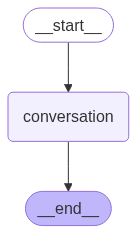

In [10]:
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Visualization error: {e}")
    print("\nGraph Structure:")
    print("START → conversation_node → END")
    print("(with SqliteSaver checkpointer for persistent conversation storage)")

## 10. Testing Persistence

Let's test the persistence capabilities by creating some conversation history.

### Persistence Test Strategy:
1. **Initial Conversation**: Create some conversation history
2. **Verify Storage**: Confirm data is in the database
3. **Simulate Restart**: Show how conversations resume
4. **Multi-User Test**: Demonstrate thread isolation with persistence

In [11]:
from langchain_core.messages import HumanMessage

# Test 1: Initial conversation to establish history
print("🧪 Test 1: Creating Persistent Conversation History")
print("=" * 60)

initial_message = "Hi! I'm Sarabjot, and I'm building a LangGraph learning repository. This is my first message in a persistent conversation."
print(f"User: {initial_message}")

for event in app.stream({"messages": [HumanMessage(content=initial_message)]}, config=config):
    for value in event.values():
        print(f"Assistant: {value['messages'].content}")

print("\n" + "=" * 60)

🧪 Test 1: Creating Persistent Conversation History
User: Hi! I'm Sarabjot, and I'm building a LangGraph learning repository. This is my first message in a persistent conversation.
Assistant: Hi Sarabjot! Welcome back!

I remember you're building a LangGraph learning repository. We've previously discussed SQLite persistence versus in-memory storage for LangGraph applications, covering the benefits of SQLite for data durability across sessions compared to faster but volatile in-memory storage.

It's great to continue helping with your LangGraph learning repository. Since you mentioned this is your "first message in a persistent conversation," I'm wondering if you might be testing the persistence aspects of conversation memory right now?

Is there something specific about LangGraph you'd like to explore today? I'm happy to discuss any aspect of LangGraph, whether it's state management, agent workflows, the computational graph model, or implementation details for your repository.



In [12]:
# Test 2: Add more context to the conversation
print("🧪 Test 2: Building Conversation Context")
print("=" * 60)

context_message = "I'm particularly interested in how SQLite persistence works compared to in-memory storage. Can you explain the key differences?"
print(f"User: {context_message}")

for event in app.stream({"messages": [HumanMessage(content=context_message)]}, config=config):
    for value in event.values():
        print(f"Assistant: {value['messages'].content}")

print("\n" + "=" * 60)

🧪 Test 2: Building Conversation Context
User: I'm particularly interested in how SQLite persistence works compared to in-memory storage. Can you explain the key differences?
Assistant: Hi Sarabjot! I see you're asking about SQLite persistence versus in-memory storage again.

As we discussed previously, here are the key differences:

**SQLite Persistence:**
- **Durability**: Data persists across application restarts or crashes
- **Storage**: Information is saved to disk in a SQLite database file
- **Memory Usage**: Lower memory footprint for large graphs as data lives primarily on disk
- **Performance**: Slightly slower due to disk I/O operations
- **Use Case**: Better for production applications, long-running conversations, or when recovering state is important

**In-Memory Storage:**
- **Speed**: Faster performance as everything stays in RAM
- **Simplicity**: Easier to set up and use for development
- **Volatility**: Data is lost when the application terminates
- **Memory Usage**: Hig

## 11. Simulating Application Restart

Let's demonstrate how conversations persist by creating a new graph instance and resuming the conversation.

### What This Demonstrates:
- **True Persistence**: Conversation survives "application restart"
- **Seamless Resume**: No loss of context or history
- **Production Readiness**: Real-world restart scenarios

In [13]:
# Simulate application restart by creating new instances
print("🔄 Simulating Application Restart...")
print("Creating new graph and memory instances...")

# Create new connection and memory (simulating restart)
new_conn = sqlite3.connect("checkpointer.sqlite", check_same_thread=False)
new_memory = SqliteSaver(new_conn)

# Create new graph instance
new_graph = StateGraph(MyState)
new_graph.add_node("conversation", conversation_node)
new_graph.add_edge(START, "conversation")
new_graph.add_edge("conversation", END)

# Compile new app with new memory instance
new_app = new_graph.compile(checkpointer=new_memory)

print("✅ New application instance created")
print("💾 Connected to same SQLite database")

🔄 Simulating Application Restart...
Creating new graph and memory instances...
✅ New application instance created
💾 Connected to same SQLite database


In [14]:
# Test 3: Resume conversation with new app instance
print("🧪 Test 3: Resuming Conversation After 'Restart'")
print("=" * 60)

resume_message = "I'm back! Do you remember our conversation about SQLite persistence? Can you summarize what we discussed?"
print(f"User: {resume_message}")

# Use the same config (thread_id) with the new app instance
for event in new_app.stream({"messages": [HumanMessage(content=resume_message)]}, config):
    for value in event.values():
        print(f"Assistant: {value['messages'].content}")

print("\n✅ Conversation successfully resumed from persistent storage!")
print("\n" + "=" * 60)

🧪 Test 3: Resuming Conversation After 'Restart'
User: I'm back! Do you remember our conversation about SQLite persistence? Can you summarize what we discussed?
Assistant: Welcome back, Sarabjot! Yes, I remember our conversations about SQLite persistence in LangGraph.

We've discussed this topic a couple of times now. I explained the key differences between SQLite persistence and in-memory storage:

For SQLite persistence:
- Provides data durability across application restarts
- Stores information on disk in a SQLite database file
- Has a lower memory footprint for large graphs
- Is slightly slower due to disk operations
- Is better suited for production applications and long-running conversations

For in-memory storage:
- Offers faster performance with data staying in RAM
- Is simpler to set up for development
- Loses all data when the application terminates
- Requires more memory as all data must fit in RAM
- Works well for development and testing environments

We also talked about ho

## 12. Interactive Chat Interface

Now let's create an interactive chat interface that demonstrates the full persistent conversation experience.

### Interactive Features:
- **Continuous Loop**: Chat until user types 'exit' or 'end'
- **Real-time Persistence**: Every message is immediately saved
- **User-friendly Interface**: Clear prompts and responses
- **Graceful Exit**: Clean termination

### Usage Instructions:
1. Type your messages and press Enter
2. The bot will respond and save the conversation
3. Type 'exit' or 'end' to stop the chat
4. Your conversation is automatically saved to SQLite

In [15]:
print(" Interactive Persistent Chat Interface")
print("=" * 60)
print("Type your messages and press Enter to chat.")
print("Type 'exit' or 'end' to stop the conversation.")
print("All messages are automatically saved to SQLite database.")
print("=" * 60)

# Interactive chat loop
while True:
    try:
        # Get user input
        user_input = input("\n👤 You: ").strip()
        
        # Check for exit conditions
        if user_input.lower() in ["end", "exit", "quit", "bye"]:
            print("\n👋 Goodbye! Your conversation has been saved to the database.")
            break
        
        # Skip empty inputs
        if not user_input:
            print("Please enter a message or type 'exit' to quit.")
            continue
        
        # Process the message through our persistent chatbot
        print("\n Assistant: ", end="")
        
        for event in new_app.stream({"messages": [HumanMessage(content=user_input)]}, config):
            for value in event.values():
                print(value['messages'].content)
                
    except KeyboardInterrupt:
        print("\n\n Chat interrupted. Your conversation has been saved to the database.")
        break
    except Exception as e:
        print(f"\n❌ Error: {e}")
        print("Please try again or type 'exit' to quit.")

print("\n All conversation data is stored in 'checkpointer.sqlite'")
print(" You can restart this notebook and resume the conversation anytime!")

 Interactive Persistent Chat Interface
Type your messages and press Enter to chat.
Type 'exit' or 'end' to stop the conversation.
All messages are automatically saved to SQLite database.

 Assistant: Hi Sarabjot! Nice to see you again. 

We've been discussing your LangGraph learning repository project and specifically exploring SQLite persistence versus in-memory storage. Would you like to continue our conversation about LangGraph implementation details, or is there something else you'd like to discuss about your project today?

I'm here to help with any questions you might have about LangGraph, state management in AI applications, or any other aspects of your learning repository.

 Assistant: Based on our previous conversations, here's what I know about you:

You're Sarabjot, and you're working on building a LangGraph learning repository. You've shown particular interest in understanding how persistence works in LangGraph, especially the differences between SQLite persistence and in-m

## 13. Database Inspection

Let's examine what's actually stored in our SQLite database.

### Database Schema:
SqliteSaver creates tables to store:
- **Checkpoints**: Conversation states at each step
- **Metadata**: Thread information and timestamps
- **Messages**: Individual conversation messages

### Inspection Benefits:
- **Debugging**: Understand how data is stored
- **Analytics**: Query conversation patterns
- **Monitoring**: Track usage and performance
- **Backup Verification**: Ensure data integrity

In [16]:
# Inspect the database structure
print(" Database Inspection")
print("=" * 50)

# Get table names
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

print(f" Tables in database: {len(tables)}")
for table in tables:
    print(f"  - {table[0]}")

# Check if we have any checkpoints
try:
    cursor.execute("SELECT COUNT(*) FROM checkpoints;")
    checkpoint_count = cursor.fetchone()[0]
    print(f"\n Total checkpoints stored: {checkpoint_count}")
    
    # Show recent checkpoints for our thread
    cursor.execute(
        "SELECT thread_id, checkpoint_id, created_at FROM checkpoints WHERE thread_id LIKE '%persistent_user_1%' ORDER BY created_at DESC LIMIT 5;"
    )
    recent_checkpoints = cursor.fetchall()
    
    if recent_checkpoints:
        print(f"\n Recent checkpoints for our conversation:")
        for checkpoint in recent_checkpoints:
            print(f"  Thread: {checkpoint[0][:30]}... | ID: {checkpoint[1][:8]}... | Time: {checkpoint[2]}")
    else:
        print("\n No checkpoints found for our thread (this is normal if you haven't chatted yet)")
        
except Exception as e:
    print(f"\n️ Could not inspect checkpoints: {e}")
    print("This is normal if no conversations have been saved yet.")

cursor.close()
print("\n Database inspection complete")

 Database Inspection
 Tables in database: 2
  - checkpoints
  - writes

 Total checkpoints stored: 50

️ Could not inspect checkpoints: no such column: created_at
This is normal if no conversations have been saved yet.

 Database inspection complete


## Key Takeaways

### What We Learned:

1. **SqliteSaver**: Persistent conversation storage with SQLite
2. **Database Persistence**: Conversations survive application restarts
3. **Production Readiness**: Suitable for real-world deployment
4. **Seamless Migration**: Easy upgrade from MemorySaver
5. **Interactive Interfaces**: Building user-friendly chat experiences
6. **Database Inspection**: Understanding the underlying storage

### When to Use SqliteSaver:

- **Production Applications**: When conversations must persist
- **Multi-session Use**: Users return to previous conversations
- **Analytics Requirements**: Need to analyze conversation data
- **Backup Needs**: Important conversations must be preserved
- **Compliance**: Audit trails and data retention requirements

### Advantages Over MemorySaver:

- **Persistence**: Data survives restarts and crashes
- **Scalability**: Can handle larger conversation histories
- **Analytics**: Query and analyze conversation data
- **Backup**: Database can be backed up and restored
- **Audit Trail**: Complete conversation history tracking


### Best Practices Demonstrated:

- **Connection Management**: Proper SQLite connection handling
- **Thread Safety**: Using `check_same_thread=False`
- **Error Handling**: Graceful handling of database errors
- **User Experience**: Interactive chat interface design
- **Data Inspection**: Tools for debugging and monitoring




### Database Alternatives:

- **PostgreSQL**: For larger scale and advanced features
- **Redis**: For high-performance, distributed applications
- **MongoDB**: For document-based conversation storage
- **Cloud Databases**: AWS RDS, Google Cloud SQL, Azure SQL
- **Vector Databases**: For semantic search capabilities